## 1. Μέρος 1ο – Ταξινόμηση με Συνελικτικά Νευρωνικά Δίκτυα (60%)


### d. Πειραματιστείτε και προτείνετε ένα CNN δικής σας έμπνευσης που να βελτιστοποιεί την ακρίβεια ταξινόμησης στο test set χωρίς ενδείξεις overfitting.

Παρακάτω, παρουσιάζεται ένα δίκτυο DenseNet για το cifar10

In [ ]:
import numpy as np 
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD,Adam,lr_scheduler
from torch.utils.data import random_split
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [ ]:
train_transform = transforms.Compose([
                                      transforms.RandomHorizontalFlip(p = 0.4), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(30), #Rotates the image to a specified angel
                                      transforms.Pad(4),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])
 
 
test_transform = transforms.Compose([
                               transforms.Pad(4),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

In [ ]:
train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=train_transform)
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trainloader = DataLoader(dataset=train_data, 
                          batch_size=128,
                          num_workers=1,
                          shuffle=True)

testloader = DataLoader(dataset=test_data, 
                         batch_size=128,
                         num_workers=1,
                         shuffle=True)

Σε αντίθεση με τα υπόλοιπα CNNs που δοκιμάστηκαν, το DenseNet BC συνδέει κάθε άλλο επίπεδο του δικτύου με feed forward λογική. Σε κάθε επίπεδο οι χάρτες των χαρακτηριστικών των προηγούμενων επιπέδων και του τωρινού επιπέδου χρησιμοποιούνται ως είσοδοι σε όλα τα επόμενα επίπεδα.
Η διαφορά με το απλό DenseNet είναι πως το transition επίπεδο παράγει θm feature maps εξόδου,αν  m feature maps που περιέχει ένα dense μπλοκ. Το θ είναι ο παράγοντας σύμπτηξης(Further Compression) και είναι από 0 εώς 1, όπου όταν θ=1, ο αριθμός των feature maps δεν αλλάζει. Και το B αναφέρεται στα Bottleneck Layers. 


Αρχικά, ορίζουμε μία κλάση Bottleneck. Τα επίπεδα Bottleneck είναι 1x1 convolutional layers, που τοποθετούνται πριν τα 3x3 conv layers για την αύξηση της ταχύτητας, καθώς ο αριθμός των εισόδων μπορεί να είναι πολύ υψηλός, ειδικά όσο προχωράμε στα επόμενα επίπεδα. Σημειώνεται, πως οι feauture maps εδώ είναι 4k. Η δομή του Bottleneck είναι η εξής: δύο conv layers με batch normalisation και ReLU ως συνάρτηση ενεργοποίησης, το 1ο με 1x1 kernel, το 2ο με 3x3 kernel.
Στη συνέχεια, ορίζουμε την κλάση Transition όπου εκεί πραγματοποιούνται convolution και pooling (συγκεκριμένα average pooling) για να μειώσουν τον αριθμό των καναλιών στο μισό.
Τέλος, ορίζεται η κλάση DenseNet, όπου οι διαστάσεις κάθε feature map είναι στθαερή αλλά αυτό που αλλάζει μεταξύ των μπλοκ είναι ο αριθμός των φίλτρων. 

In [ ]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        #"""In  our experiments, we let each 1×1 convolution
        #produce 4k feature-maps."""
        inner_channel = 4 * growth_rate

        #"""We find this design especially effective for DenseNet and
        #we refer to our network with such a bottleneck layer, i.e.,
        #to the BN-ReLU-Conv(1×1)-BN-ReLU-Conv(3×3) version of H ` ,
        #as DenseNet-B."""
        self.bottle_neck = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, inner_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(inner_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(inner_channel, growth_rate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        return torch.cat([x, self.bottle_neck(x)], 1)

#"""We refer to layers between blocks as transition
#layers, which do convolution and pooling."""
class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        #"""The transition layers used in our experiments
        #consist of a batch normalization layer and an 1×1
        #convolutional layer followed by a 2×2 average pooling
        #layer""".
        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)

#DesneNet-BC
#B stands for bottleneck layer(BN-RELU-CONV(1x1)-BN-RELU-CONV(3x3))
#C stands for compression factor(0<=theta<=1)
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_class=10):
        super().__init__()
        self.growth_rate = growth_rate

        #"""Before entering the first dense block, a convolution
        #with 16 (or twice the growth rate for DenseNet-BC)
        #output channels is performed on the input images."""
        inner_channels = 2 * growth_rate

        #For convolutional layers with kernel size 3×3, each
        #side of the inputs is zero-padded by one pixel to keep
        #the feature-map size fixed.
        self.conv1 = nn.Conv2d(3, inner_channels, kernel_size=3, padding=1, bias=False)

        self.features = nn.Sequential()

        for index in range(len(nblocks) - 1):
            self.features.add_module("dense_block_layer_{}".format(index), self._make_dense_layers(block, inner_channels, nblocks[index]))
            inner_channels += growth_rate * nblocks[index]

            #"""If a dense block contains m feature-maps, we let the
            #following transition layer generate θm output feature-
            #maps, where 0 < θ ≤ 1 is referred to as the compression
            #fac-tor.
            out_channels = int(reduction * inner_channels) # int() will automatic floor the value
            self.features.add_module("transition_layer_{}".format(index), Transition(inner_channels, out_channels))
            inner_channels = out_channels

        self.features.add_module("dense_block{}".format(len(nblocks) - 1), self._make_dense_layers(block, inner_channels, nblocks[len(nblocks)-1]))
        inner_channels += growth_rate * nblocks[len(nblocks) - 1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('relu', nn.ReLU(inplace=True))

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.linear = nn.Linear(inner_channels, num_class)

    def forward(self, x):
        output = self.conv1(x)
        output = self.features(output)
        output = self.avgpool(output)
        output = output.view(output.size()[0], -1)
        output = self.linear(output)
        return output

    def _make_dense_layers(self, block, in_channels, nblocks):
        dense_block = nn.Sequential()
        for index in range(nblocks):
            dense_block.add_module('bottle_neck_layer_{}'.format(index), block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return dense_block

def densenet121():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

def densenet169():
    return DenseNet(Bottleneck, [6,12,32,32], growth_rate=32)

def densenet201():
    return DenseNet(Bottleneck, [6,12,48,32], growth_rate=32)

def densenet161():
    return DenseNet(Bottleneck, [6,12,36,24], growth_rate=48)

In [ ]:
# number of epochs
epochs = 50
# learning rate
learning_rate = 0.001
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
model = densenet121()

In [ ]:
criterion = nn.CrossEntropyLoss()

# set optimizer, only train the classifier parameters, feature parameters are frozen
optimizer = Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss', 'Train accuracy', 'Test loss', 'Test accuracy']) 

In [ ]:
#train the model
model.to(device)

steps = 0
running_loss = 0
for epoch in range(epochs):
    
    since = time.time()
    
    train_accuracy = 0

    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # calculate train top-1 accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
       
        
    time_elapsed = time.time() - since
    test_loss = 0
    test_accuracy = 0

    model.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            test_loss += batch_loss.item()

            # Calculate test top-1 accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
          
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time per epoch: {time_elapsed:.4f}.. "
          f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
          f"Train loss: {running_loss/len(trainloader):.4f}.. "
          f"Train accuracy: {train_accuracy/len(trainloader):.4f}.. "
          f"Test loss: {test_loss/len(testloader):.4f}.. "
          f"Test accuracy: {test_accuracy/len(testloader):.4f}.. ")
  
    train_stats = train_stats.append({'Epoch': epoch, 'Time per epoch':time_elapsed, 'Avg time per step': time_elapsed/len(trainloader), 'Train loss' : running_loss/len(trainloader), 'Train accuracy': train_accuracy/len(trainloader),'Test loss' : test_loss/len(testloader), 'Test accuracy': test_accuracy/len(testloader)}, ignore_index=True)
    running_loss = 0
    model.train()

Epoch 1/50.. Time per epoch: 254.2141.. Average time per step: 0.6502.. Train loss: 1.6216.. Train accuracy: 0.3974.. Test loss: 1.4385.. Test accuracy: 0.4765.. 
Epoch 2/50.. Time per epoch: 263.7910.. Average time per step: 0.6747.. Train loss: 1.2574.. Train accuracy: 0.5397.. Test loss: 1.4979.. Test accuracy: 0.5173.. 
Epoch 3/50.. Time per epoch: 263.8578.. Average time per step: 0.6748.. Train loss: 1.0905.. Train accuracy: 0.6059.. Test loss: 1.0041.. Test accuracy: 0.6417.. 
Epoch 4/50.. Time per epoch: 264.2318.. Average time per step: 0.6758.. Train loss: 0.9720.. Train accuracy: 0.6519.. Test loss: 0.8665.. Test accuracy: 0.6883.. 
Epoch 5/50.. Time per epoch: 264.3613.. Average time per step: 0.6761.. Train loss: 0.8883.. Train accuracy: 0.6842.. Test loss: 0.7385.. Test accuracy: 0.7385.. 
Epoch 6/50.. Time per epoch: 264.0759.. Average time per step: 0.6754.. Train loss: 0.8136.. Train accuracy: 0.7124.. Test loss: 0.7560.. Test accuracy: 0.7370.. 
Epoch 7/50.. Time per 

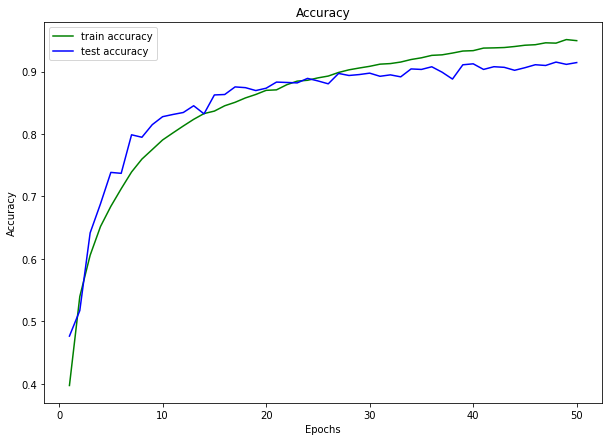

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy");

x = range(1, len(train_stats['Train accuracy'].values) + 1)
ax.plot(x, train_stats['Train accuracy'].values, '-g', label='train accuracy');
ax.plot(x, train_stats['Test accuracy'].values, '-b', label='test accuracy');

plt.legend()

Παρατηρούμε, πως με τη χρήση DenseNet φτάσαμε την υψηλότερη απόδοση μέχρι 91% στο cifar-10 dataset. 